***METRICS TO EVALUATE SEGMENTATION***

In [1]:
import torch
from unet import *
from camvid_unet import *
import sklearn as sk
from deeplab2.deeplabv3 import DeepLabV3Plus
from deeplab2 import encoders

import metrics_sauc
from sklearn.metrics import classification_report
import dataset 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as A
import os
import pandas as pd

import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import numpy as np
import cv2
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%config Completer.use_jedi = False

In [2]:
def transformation():  
    transform = [A.RandomCrop(width=256, height=256)]
    return A.Compose(transform)
    

In [3]:
DATA_DIR = './data/CamVid/'
x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [4]:
test_data = dataset.Dataset(x_test_dir, y_test_dir, augmentation = None)

In [6]:
###############################################################
#           LOAD THE MODEL THAT YOU WANT TO EVALUATE          #
###############################################################

#model = CamvidUNet(3,12)
#model = DeepLabV3Plus(
            #encoder_name = "resnet34",
            #encoder_depth = 5,
            #encoder_weights = "imagenet",
            #encoder_output_stride = 16,
            #decoder_channels = 256,
            #decoder_atrous_rates = (6, 12, 18),
            #in_channels = 3,
            #classes = 12,
            #upsampling = 4)
model = CamvidUNet(3,12)
#model = torch.hub.load('pytorch/vision:v0.9.0', 'deeplabv3_resnet101', pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('new_camvid/dlv3p_finetune_wce_adam_0001.pth');
model.to(device)
model.eval();

In [6]:

model = torch.hub.load('pytorch/vision:v0.9.0', 'deeplabv3_resnet101', pretrained=True)
model = torch.load('deeplabV3/wce_adam_0001.pth')
if torch.cuda.is_available():
    model.cuda()
model.eval();

Using cache found in /home/usuaris/imatge/manel.davins/.cache/torch/hub/pytorch_vision_v0.9.0


In [7]:
###############################################################
#       USE THE MODEL TO PREDICT OVER THE TEST SET            #
###############################################################

true_masks = []
predicted_masks = []
for n in range(0,len(test_data)):
    
    image, true_mask = test_data[n] #3*360*480, 360*480
    
    image = image.to(device).unsqueeze(0)#1*3*360*480

    output = model(image)#[1, Nclasses, 360, 480]
    output = torch.sigmoid(output)
    output = output.detach().cpu()
    
    output = output.squeeze(0).numpy() #(360, 480, Nclasses)
    
    output_onelayer = np.argmax(output, axis=0)
    true_mask = true_mask.detach().cpu().numpy()
    
    true_masks.append(true_mask)
    predicted_masks.append(output_onelayer) 
    
y_true = np.reshape(true_masks, -1)
y_pred = np.reshape(predicted_masks, -1)

***1. GENERAL METRICS (PRECISION, RECALL, F1, ACCURACY)***

In [8]:
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
print(classification_report(y_true, y_pred, target_names=CLASSES))

KeyboardInterrupt: 

In [ ]:
print('Pixel accuracy is {0:.2f}'.format(sk.metrics.accuracy_score(y_true, y_pred)))

***2. CONFUSION MATRIX***

<AxesSubplot:>

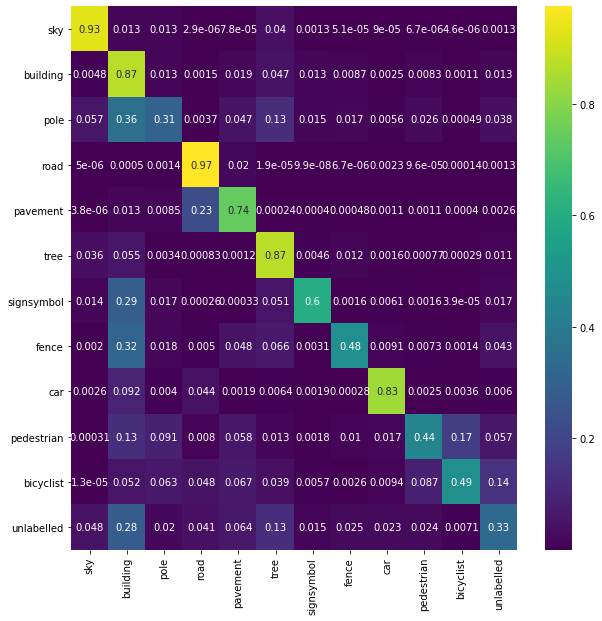

In [11]:
conf_mat = confusion_matrix(y_true, y_pred, normalize='true')
dataframe = pd.DataFrame(conf_mat, index = CLASSES, columns=CLASSES)
plt.figure(figsize = (10,10))
sn.heatmap(dataframe, annot=True, cmap='viridis')

***3. CLASS IoU and mIoU***

In [7]:
conf_mat = confusion_matrix(y_true, y_pred)

In [8]:
pos = conf_mat.sum(1) # positives
res = conf_mat.sum(0) # prediction
tp = np.diag(conf_mat) # true_positives

pixel_acc = tp.sum()/pos.sum()
IoU_array = (tp / (pos + res - tp))

mean_IoU = IoU_array.mean()
weights = [0.1681, 0.2498, 0.01199, 0.2547, 0.0933, 0.1136, 0.0103, 0.0121, 0.04055, 0.0064, 0.0019, 0.0369]
weighted_iou = sum([i*j for (i, j) in zip(IoU_array, weights)])

In [9]:
https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/

array([ 6611359,  9832770,   472179, 10034270,  3676744,  4480992,
         405823,   476807,  1597571,   255232,    75948,  1447985])

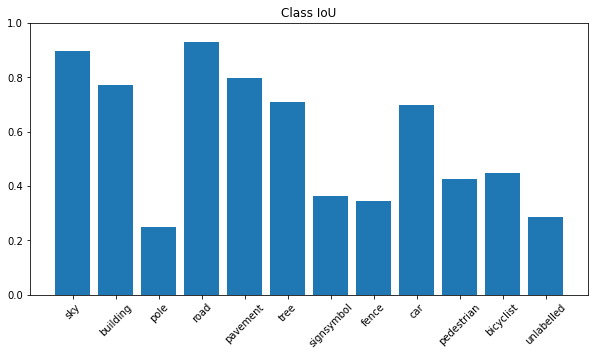

In [26]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
plt.ylim([0,1])
plt.title('Class IoU')
plt.bar(CLASSES, IoU_array);

In [27]:
print("Mean IoU: {0:.2f}   Weighted IoU: {1:.2f}".format(mean_IoU, weighted_iou))

Mean IoU: 0.58   Weighted IoU: 0.79


***4. SAMPLE IMAGES***

In [14]:
def visualize(image, gt_mask):
    colormap = {
    0: [180, 255, 255], #sky
    1: [152, 122, 70], #building
    2: [255, 0, 0], #pole
    3: [168, 168, 168], #road
    4: [253, 153, 51], #pavement
    5: [0, 204, 0], #tree
    6: [255, 255, 0], #signsymbol
    7: [110, 30, 0], #fence
    8: [0, 0, 0], #car
    9: [255, 100, 255], #pedestrian
    10: [50, 70, 255], #bicyclist
    11: [255, 255, 255], #unlabelled 
    }
    gt_mask = gt_mask.detach().cpu().numpy()
    image = image.to(device).unsqueeze(0)#1*3*360*480
    prediction = model(image)['out']#[1, 12, 360, 480]
    prediction = prediction.detach().cpu().squeeze(0).numpy()#(12,360, 480)
    prediction = np.argmax(prediction, axis=0)
    
    color_gt = np.zeros((prediction.shape[0],prediction.shape[1],3))
    color_pred = np.zeros((prediction.shape[0],prediction.shape[1],3))
    
    
    
    for c in colormap.keys():
        color_pred[prediction==c] = colormap[c]
        color_gt[gt_mask==c] = colormap[c]
        
    color_gt = np.uint8(color_gt)
    color_pred = np.uint8(color_pred)
        
    return color_gt, color_pred

In [ ]:
def visualize(image, gt_mask):
    colormap = {
    0: [180, 255, 255], #sky
    1: [152, 122, 70], #building
    2: [255, 0, 0], #pole
    3: [168, 168, 168], #road
    4: [253, 153, 51], #pavement
    5: [0, 204, 0], #tree
    6: [255, 255, 0], #signsymbol
    7: [110, 30, 0], #fence
    8: [0, 0, 0], #car
    9: [255, 100, 255], #pedestrian
    10: [50, 70, 255], #bicyclist
    11: [255, 255, 255], #unlabelled 
    }
    gt_mask = gt_mask.detach().cpu().numpy()
    image = image.to(device).unsqueeze(0)#1*3*360*480
    prediction = model(image)['out']#[1, 12, 360, 480]
    prediction = prediction.detach().cpu().squeeze(0).numpy()#(12,360, 480)
    prediction = np.argmax(prediction, axis=0)
    
    color_gt = np.zeros((prediction.shape[0],prediction.shape[1],3))
    color_pred = np.zeros((prediction.shape[0],prediction.shape[1],3))
    
    
    
    for c in colormap.keys():
        color_pred[prediction==c] = colormap[c]
        color_gt[gt_mask==c] = colormap[c]
        
    color_gt = np.uint8(color_gt)
    color_pred = np.uint8(color_pred)
        
    return color_gt, color_pred

In [8]:
def visualize_v2(image, gt_mask):
    
    
    classes = pd.read_csv('data/CamVid/class_dict.csv', index_col = 0)
    cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}
    idx2rgb={idx:tuple(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}
    
    gt_mask = gt_mask.detach().cpu().numpy()
    image = image.to(device).unsqueeze(0)#1*3*360*480
    prediction = model(image)#[1, Nclasses, 360, 480]
    prediction = prediction.detach().cpu().squeeze(0).numpy()#(Nclasses,360, 480)
    prediction = np.argmax(prediction, axis=0)
    
    color_gt = np.zeros((prediction.shape[0],prediction.shape[1],3))
    color_pred = np.zeros((prediction.shape[0],prediction.shape[1],3))
    
    for c in idx2rgb.keys():
        color_pred[prediction==c] = idx2rgb[c]
        color_gt[gt_mask==c] = idx2rgb[c]
        
    color_gt = np.uint8(color_gt)
    color_pred = np.uint8(color_pred)
        
    return color_gt, color_pred

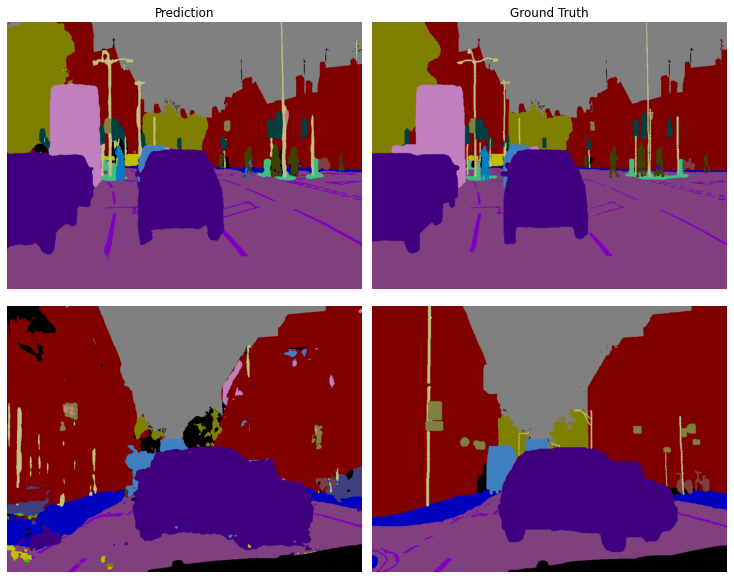

In [12]:
image_1, true_mask_1 = test_data[1]
image_2, true_mask_2 = test_data[19]

vis_gt_1, vis_pred_1 = visualize_v2(image_1, true_mask_1)
vis_gt_2, vis_pred_2 = visualize_v2(image_2, true_mask_2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(10,8))
ax1.imshow(vis_pred_1)
ax2.imshow(vis_gt_1)
ax3.imshow(vis_pred_2)
ax4.imshow(vis_gt_2)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax1.set_title('Prediction')
ax2.set_title('Ground Truth')
plt.tight_layout(pad=0, w_pad=1, h_pad=1)

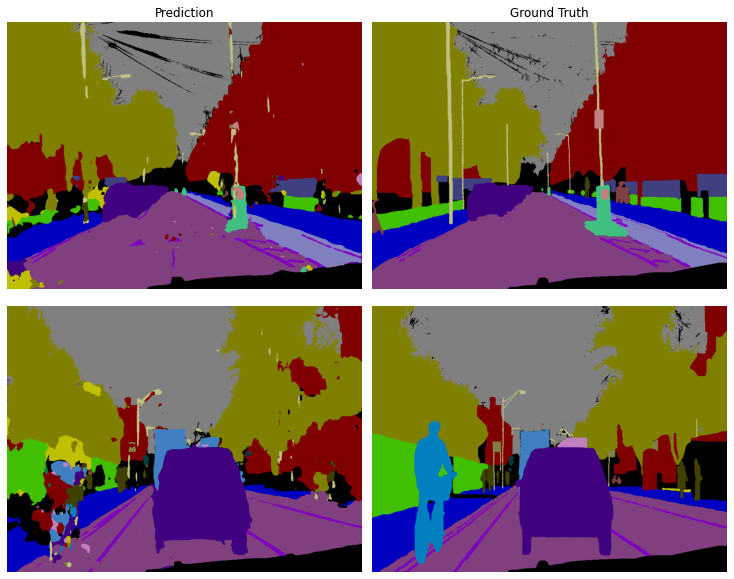

In [13]:
image_1, true_mask_1 = test_data[230]
image_2, true_mask_2 = test_data[77]

vis_gt_1, vis_pred_1 = visualize_v2(image_1, true_mask_1)
vis_gt_2, vis_pred_2 = visualize_v2(image_2, true_mask_2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(10,8))
ax1.imshow(vis_pred_1)
ax2.imshow(vis_gt_1)
ax3.imshow(vis_pred_2)
ax4.imshow(vis_gt_2)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax1.set_title('Prediction')
ax2.set_title('Ground Truth')
plt.tight_layout(pad=0, w_pad=1, h_pad=1)